In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/SSD/Code/TinyMPC/julia/quadrotor_quat/Project.toml`


In [2]:
using LinearAlgebra
using BlockDiagonals
using ForwardDiff
using Plots
using Random; 
using JuMP
using COSMO
using Printf
using ControlSystems

In [3]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end
function E(q)
    E = BlockDiagonal([1.0*I(3), G(q), 1.0*I(6)])
end

E (generic function with 1 method)

In [524]:
#Quadrotor parameters
m = 0.027
J = [16.6e-6 0.83e-6 0.72e-6;
    0.83e-6 16.6e-6 1.8e-6;
    0.72e-6 1.8e-6 29.3e-6];
# J = Array(diagm([1.4194e-05, 1.4089e-05, 2.9741e-05]))
g = 9.81

h = 1/500 #500 Hz

Nx = 13     # number of states (quaternion)
Nx̃ = 12
Nz = 3
Nu = 4     # number of controls
Tfinal = 3.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
t_vec = h*(0:Nt-1)
thist = Array(range(0,h*(Nt-1), step=h));

In [525]:
function quad_dynamics(x,u)
    r = x[1:3]
    q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
    v = x[8:10]
    ω = x[11:13]
    Q = qtoQ(q)
    
    ṙ = Q*v
    q̇ = 0.5*L(q)*H*ω
    
    v̇ = Q'*[0; 0; -g] + (1/m)*[0; 0; u[1]] - hat(ω)*v
    
    ω̇ = J\(-hat(ω)*J*ω + u[2:4])
    
    return [ṙ; q̇; v̇; ω̇]
end

quad_dynamics (generic function with 1 method)

In [526]:
function quad_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
    return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [393]:
#Initial Conditions
# uhover = (m*g/4)*ones(4)
uhover = [m*g; 0; 0; 0]
r0 = [0.0; 0; 1.0]
q0 = [1.0; 0; 0; 0]
v0 = zeros(3)
ω0 = zeros(3)
x0 = [r0; q0; v0; ω0];

In [394]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),x0)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(x0,u),uhover);
#Reduced system
Ã = Array(E(q0)'*A*E(q0))
B̃ = Array(E(q0)'*B);

In [521]:
# Z_aug = Array([I(Nz)*h zeros(Nz,Nx̃ - Nz)])  # augment integral of ex and ey
Z_aug = Array([0 0 h zeros(Nz,Nx̃ - 3)])  # augment integral of ex and ey
A_aug = [Ã zeros(Nx̃, Nz);
         Z_aug Array(I(Nz))]     
B_aug = [B̃; zeros(Nz, Nu)]
#Controlability Matrix
C = B_aug
for k = 1:(Nx-1)
    C = [C A_aug*C[:,end-(Nu-1):end]]
end
rank(C) #Reduced system is controllable

13

In [517]:
# Cost weights/Bryson's rules
max_dev_x = [0.05; 0.05; 0.05;  0.05; 0.05; 0.05;  0.1; 0.1; 0.1;  0.1; 0.1; 0.1;  0.005]
max_thrust = 60*1e-3*9.81/2
thrustToTorque = 0.005964552
arm = 0.046/sqrt(2)
max_torque_x = max_thrust*arm/2
max_torque_z = thrustToTorque*max_thrust/2
max_dev_u = [max_thrust; max_torque_x; max_torque_x; max_torque_z]/50
Q_aug = Array(diagm(1 ./(max_dev_x.^2)))
R = Array(diagm(1 ./(max_dev_u.^2)))
#LQR Controller
K = dlqr(A_aug,B_aug,Q_aug,R)

4×13 Matrix{Float64}:
 2.12859e-10  -1.11457e-9   0.699021     …   5.79446e-11   1.16837
 4.75954e-6   -0.00179588  -1.22194e-9      -3.95483e-6   -3.30007e-9
 0.00179501   -4.87416e-6   1.40025e-8      -9.92428e-6    4.09419e-8
 5.15848e-6   -2.02682e-6  -3.29728e-11      0.000201484   1.15522e-10

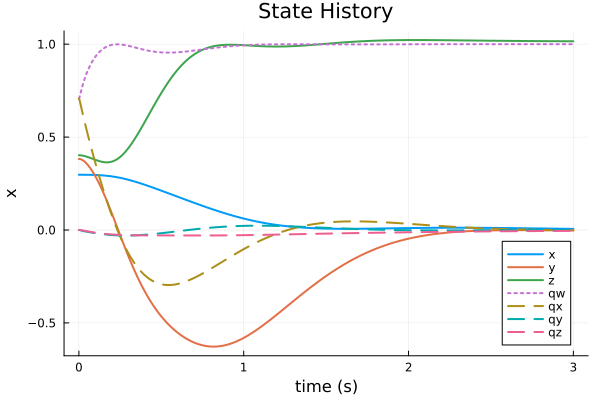

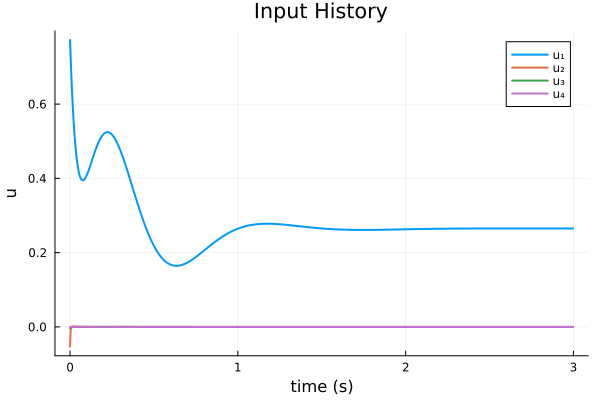

In [505]:
#Feedback controller
z = zeros(Nz)
function controller(x)
    
    q0 = x0[4:7]
    q = x[4:7]
    ϕ = qtorp(L(q0)'*q)
    z .+= (x[3]-r0[3])*h  # integral state
    Δx̃ = [x[1:3]-r0; ϕ; x[8:10]-v0; x[11:13]-ω0; z]
    
    u = uhover - K*Δx̃
end
#Simulation
Random.seed!(1);
uhist = zeros(Nu,Nt-1)
xhist = zeros(Nx,Nt)
xhist[:,1] = [r0+randn(3); L(q0)*rptoq([1; 0; 0]); v0; ω0]
for k = 1:(Nt-1)
    uhist[:,k] = controller(xhist[:,k])
    xhist[:,k+1] = quad_dynamics_rk4(xhist[:,k],uhist[:,k])
end
display(plot(t_vec,xhist[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz" ],
linestyle=[:solid :solid :solid :dot :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State History", xlabel="time (s)", ylabel="x"))
display(plot(t_vec[1:end-1],uhist',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input History", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))

In [498]:
xhist[1:3,Nt] - r0

3-element Vector{Float64}:
  0.008445075235453237
 -0.004113921810641855
  0.027818562931851476

In [ ]:
#Set up visualization
using TrajOptPlots
using MeshCat
using StaticArrays
using RobotZoo:Quadrotor

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8703
└ @ MeshCat /home/khai/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8703))

In [ ]:
model = Quadrotor()
TrajOptPlots.set_mesh!(vis, model)

false

In [377]:
scale = 65535
display(K)
# C Language
@printf("FOR C:\n");
str = "static float K[NU][NXt] = {\n"
for i = 1:4
  str = str * "  {"
  for j = 1:(Nx̃ + Nz)
    # if abs(K[i, j]) < 1e-6
    #   K[i, j] = 0.0
    # end
    this_str = @sprintf("%.6f", K[i, j]*scale)

    str = str * this_str * "f"
    if j < (Nx̃ + Nz)
      str = str * ","
    end
  end
  str = str * "},\n"
end
str = str * "};"
@printf("%s",str)

@printf("\n\nFOR PYTHON:\n");
# Python Language
str = "K = np.array([\n"
for i = 1:4
  str = str * "  ["
  for j = 1:(Nx̃ + Nz)
    # if abs(K[i, j]) < 1e-6
    #   K[i, j] = 0.0
    # end
    this_str = @sprintf("%.6f", K[i, j]*scale)

    str = str * this_str 
    if j < (Nx̃ + Nz)
      str = str * ","
    end
  end
  str = str * "],\n"
end
str = str * "])"
@printf("%s",str)


4×13 Matrix{Float64}:
  5.47284e-9   -1.48947e-7    0.70174      …   3.19254e-10   0.034117
 -2.99077e-11  -0.00541535    4.08749e-11     -8.30057e-12  -5.80911e-12
  0.00539036    3.68075e-8   -1.75101e-10      3.22581e-10  -4.53349e-10
 -8.37558e-15   2.19149e-11  -9.47875e-14      0.00194057    3.36478e-13

FOR C:
static float K[NU][NXt] = {
  {0.000359f,-0.009761f,45988.498955f,0.036861f,0.002127f,0.002779f,0.000328f,-0.006043f,25741.775757f,0.000030f,0.000002f,0.000021f,2235.859163f},
  {-0.000002f,-354.894687f,0.000003f,3330.147095f,-0.000020f,-0.000077f,-0.000002f,-389.822686f,0.000000f,359.223869f,-0.000000f,-0.000001f,-0.000000f},
  {353.257013f,0.002412f,-0.000011f,-0.031242f,3314.724055f,0.003178f,388.021202f,0.003267f,-0.000001f,-0.000025f,357.554063f,0.000021f,-0.000030f},
  {-0.000000f,0.000001f,-0.000000f,-0.000010f,0.000000f,126.204253f,-0.000000f,0.000001f,-0.000000f,-0.000000f,0.000000f,127.175058f,0.000000f},
};



FOR PYTHON:
K = np.array([
  [0.000359,-0.009761,45988.498955,0.036861,0.002127,0.002779,0.000328,-0.006043,25741.775757,0.000030,0.000002,0.000021,2235.859163],
  [-0.000002,-354.894687,0.000003,3330.147095,-0.000020,-0.000077,-0.000002,-389.822686,0.000000,359.223869,-0.000000,-0.000001,-0.000000],
  [353.257013,0.002412,-0.000011,-0.031242,3314.724055,0.003178,388.021202,0.003267,-0.000001,-0.000025,357.554063,0.000021,-0.000030],
  [-0.000000,0.000001,-0.000000,-0.000010,0.000000,126.204253,-0.000000,0.000001,-0.000000,-0.000000,0.000000,127.175058,0.000000],
])

In [36]:
# c = [0.000000	-0.000000	0.000000	-0.000000	0.830443	-0.276140	-0.384219	0.180493]
# c = [-0.000000	0.000000	-0.000000	0.000000	-1.356107	0.688430	0.587426	-0.329106]
# c = [0.396058	0.918033	0.128965	-0.773546	0.339704	0.034310	-0.026417	-0.030049]
# c = [-0.445604	-0.684403	0.888433	1.493630	-1.361618	-0.139316	0.158875	0.095799]
# c = [0.922409	0.405715	-0.582968	-0.092188	-0.114670	0.101046	0.075834	-0.037926]
# c = [-0.291165	0.967514	0.421451	-1.086348	0.545211	0.030109	-0.050046	-0.068177]
# c = [0.923174	-0.431533	-0.682975	0.177173	0.319468	-0.043852	-0.111269	0.023166]
# c = [0.289869	0.724722	-0.512011	-0.209623	-0.218710	0.108797	0.128756	-0.055461]
# c = [0.405364	-0.834716	0.158939	0.288175	-0.373738	-0.054995	0.036090	0.078627]
# c = [0.450742	-0.385534	-0.954089	0.128288	0.442620	0.055630	-0.060142	-0.076163]
# c = [0.001062	-0.646270	-0.012560	-0.324065	0.125327	0.119738	0.034567	-0.063130]
# c = [0.001593	-1.031457	0.015159	0.820816	-0.152665	-0.130729	-0.045679	0.080444]
# c = [-0.402804	-0.820508	-0.132914	0.236278	0.235164	-0.053551	-0.088687	0.031253]
# c = [-0.449354	-0.411507	0.902946	0.185335	-0.239125	-0.041696	0.016857	0.016709]
# c = [-0.921641	-0.464596	0.661875	0.286582	-0.228921	-0.051987	0.004669	0.038463]
# c = [-0.292459	0.777682	0.565788	-0.432472	-0.060568	-0.082048	-0.009439	0.041158]
# c = [-0.923935	0.447832	0.627381	-0.259808	-0.042325	-0.032258	0.001420	0.005294]
# c = [0.288570	0.873350	-0.515586	-0.730207	-0.026023	0.288755	0.215678	-0.148061]
# c = [-0.398611	0.850510	-0.144007	-0.485368	-0.079781	0.176330	0.234482	-0.153567]
# c = [0.447039	-0.532729	-0.855023	0.878509	0.775168	-0.391051	-0.713519	0.391628]

s = 0.0
t = 0.6  # start from 0 to [duration]
for k = 0:7
  s += t^k * c[k+1]
end
s

0.0570780461568